# 6. GO/STOP! - Object Detection 시스템 만들기

## 1. 들어가며

<img src="./image/car.jpg" />
<center><b>[출처: https://unsplash.com/photos/mpSeLIXMnpc]</b></center>

이번 시간에는 object detection 모델을 통해 주변에 다른 차나 사람이 가까이 있는지 확인한 후 멈출 수 있는 자율주행 시스템을 만들어 보겠다. 하지만 자율주행 시스템은 아직 완전하지 않기 때문에, 위험한 상황에서는 운전자가 직접 운전할 수 있도록 하거나 판단이 어려운 상황에서는 멈추도록 설계된다. 우리도 같은 구조를 가진 미니 자율주행 시스템을 만들어 볼 것이다.

먼저 전체적인 시스템을 구성하기 위해서 보조장치의 역할과 이를 학습하기 위한 데이터셋 전처리를 수행하겠다. Detection 모델을 학습시키기 위한 전체 파이프라인을 직접 제작하기에는 많은 시간이 들기 때문에 RetinaNet이라는 1-stage detector를 미리 학습시킨 라이브러리를 활용하도록 하겠다.

### 실습 목표
---
1. 바운딩 박스(bounding box) 데이터셋을 전처리할 수 있다.
2. Object detection 모델을 학습할 수 있다.
3. Detection 모델을 활용한 시스템을 만들 수 있다.

### 학습 내용
---
1. 자율주행 보조장치
2. RetinaNet
3. keras-retinanet
4. 프로젝트: 자율주행 보조 시스템 만들기

### 준비물
---
아직 경로를 생성하지 않았다면 터미널을 열고 개인 실습 환경에 따라 경로를 수정, 프로젝트를 위한 디렉토리를 생성하자.

```bash
$ mkdir -p ~/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/data
```

__(주의)__ [RetinaNet 홈페이지](https://github.com/fizyr/keras-retinanet)에 보면 __tensorflow 2.3.0, tf.keras 2.4.0__을 사용할 것을 권장하며, 그보다 높은 버전에서는 오류가 발생한다고 안내하고 있다. 만약 가상환경에 설치된 Tensorflow 버전이 2.3.0보다 높을 경우 2.3.0에 맞추어 재설치하거나,<br>
아니면 별도의 가상환경을 생성 후 해당 환경에서 jupyter notebook으로 실습을 진행할 것을 권한다.

```bash
$ pip uninstall tensorflow
$ pip install tensorflow==2.3.0
```

프로젝트 디렉토리로 이동한다. 그 후 다음 리포지토리(repository)를 받고, 리포지토리 사용에 필요한 케라스 라이브러리를 가상환경 내에 설치해준다.

```bash
$ cd ~/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection
$ git clone https://github.com/fizyr/keras-retinanet.git
$ cd keras-retinanet && python setup.py build_ext --inplace
```

필요사항을 설치하고, `keras-retinanet` 또한 pip 패키지로 인스톨해준다.

```bash
$ pip install tensorflow_datasets tqdm
$ pip install -r requirements.txt
$ pip install .
```

## 2. 자율주행 보조장치 (1) KITTI 데이터셋
이번 시간에 만들어 볼 자율주행 보조장치는 카메라에 사람이 가까워졌을 때, 그리고 차가 가까워져서 탐지된 크기가 일정 이상일 때 멈춰야한다.

>__*자율주행 보조장치 object detection 요구사항*__
>
>* _1) 사람이 카메라에 감지되면 정지_
>* _2) 차량이 일정 크기 이상으로 감지되면 정지_

<img src="./image/KITTI_car.jpg" />
<center><b>[출처: http://www.cvlibs.net/datasets/kitti/]</b></center>

이번 시간에는 `tensorflow_datasets`에서 제공하는 KITTI 데이터셋을 사용해보겠다. KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D objecte detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있다.

* [cvlibs에서 제공하는 KITTI 데이터셋](http://www.cvlibs.net/datasets/kitti/)

먼저 필요한 라이브러리를 불러오겠다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


아래 코드를 통해서 KITTI 데이터셋을 다운로드하자.

>_(주의) 이 데이터셋은 11GB가 넘어가는 대용량 데이터셋이다. 다운로드 소요시간이 수시간 이상 지속될 수 있다._

In [3]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

다운로드한 KITTI 데이터셋을 `tfds.show_examples`를 통해 보도록하자. 우리가 일반적으로 보는 사진보다 광각으로 촬영되어 다양한 각도의 물체를 확인할 수 있다.

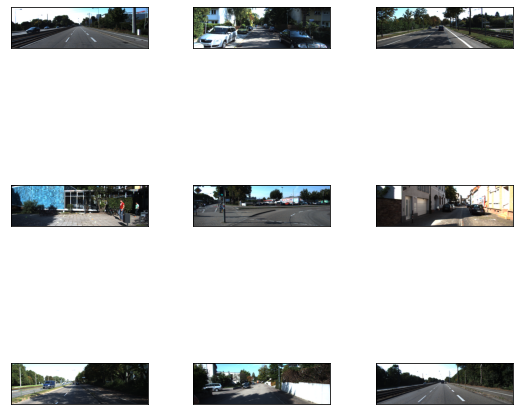

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

데이터 다운로드 시 담아둔 `ds_info`에서는 불러온 데이터셋의 정보를 확인할 수 있다. 오늘 사용할 데이터셋은 7,481개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성되어 있다. 라벨에는 `alpha`, `bbox`, `dimensions`, `location`, `occluded`, `rotation_y`, `truncated` 등의 정보가 있다.

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel-dj10/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
    

## 3. 자율주행 보조장치 (2) 데이터 직접 확인하기
이번에는 데이터셋을 직접 확인하는 시간을 갖도록 하겠다. `ds_train.take(1)`을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 `TakeDataset`을 얻을 수 있다. 이렇게 뽑은 데이터에는 `image` 등의 정보가 포함되어 있다.

눈으로 확인해서 학습에 사용할 데이터를 직접 이해해보자.

In [6]:
TakeDataset = ds_train.take(1)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([1.88, 1.73, 1.7 , 1.8 ], dtype=float32)>, 'bbox': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.10402667, 0.23228663, 0.5044    , 0.40313205],
       [0.27629334, 0.35808372, 0.5632    , 0.45037842],
       [0.34890667, 0.4195008 , 0.53642666, 0.48252013],
       [0.42088   , 0.49069244, 0.5076    , 0.5308615 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[1.56, 1.55, 3.64],
       [1.91, 1.66, 4.22],
       [1.83, 1.69, 4.28],
       [1.51, 1.63, 4.03]], dtype=float32)>, 'location': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[-2.62,  1.75,  9.48],
       [-2.12,  1.77, 14.99],
       [-1.38,  1.88, 21.  ],
       [ 1.26,  2.13, 36.44]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 1, 0])>, 'rotation_y': <tf.Tensor: shape=(4,), dtype=float32

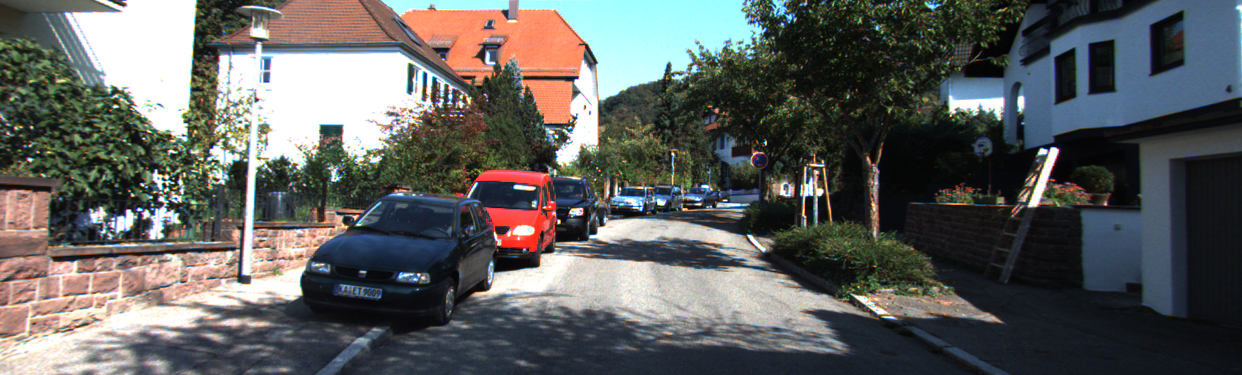

In [7]:
for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

이미지와 라벨을 얻는 방법을 알게 되었다. 그렇다면 이렇게 얻은 이미지의 바운딩 박스(bounding box, `bbox`)를 확인하기 위해서는 어떻게 해야 할까?

아래는 KITTI에서 제공하는 데이터셋에 대한 설명이다.

```python
데이터셋 이해를 위한 예시
Values    Name      Description
----------------------------------------------------------------------------
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Float from 0 (non-truncated) to 1 (truncated), where
                     truncated refers to the object leaving image boundaries
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
```

<img src="./image/KITTI_ex.png" />
<center><b>[KITTI 원본이미지 예시]</b></center>

<img src="./image/KITTI_ex_bb.png" />
<center><b>[KITTI 이미지 바운딩 박스 시각화 예시]</b></center>

위 설명과 예시 이미지를 참고하셔서 이미지 위에 바운딩 박스를 그려서 시각화해보자!

힌트: [Pillow 라이브러리의 `ImageDraw` 모듈](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html)을 참고하자.

width: 1242  height: 375
(4, 4)
[288.5     335.99    500.69    185.84999]
[444.74 271.39 559.37 163.8 ]
[521.02 244.16 599.29 173.84]
[609.44    217.17    659.32996 184.65   ]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7FC6C1FD06D0>


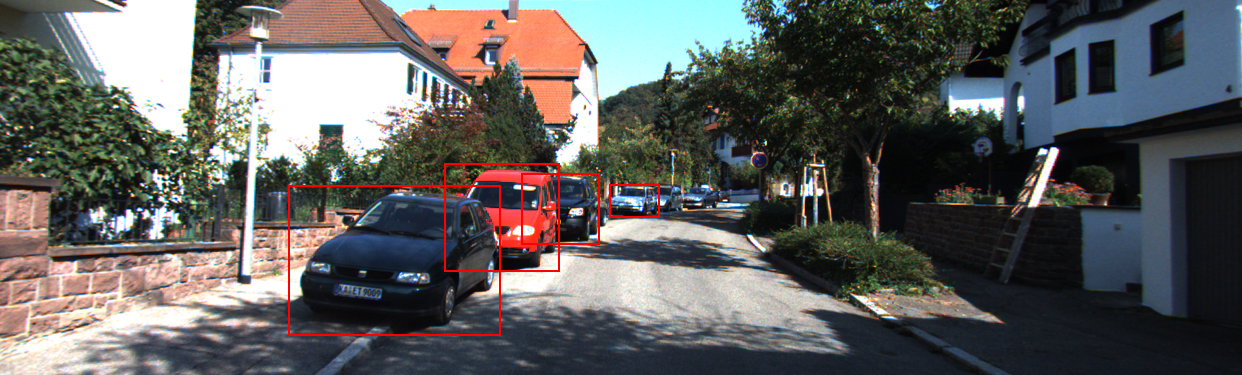

In [8]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 4. RetinaNet

> __*주요 참고 자료*__
>
> * _[Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002)_
> * _[kimcando94님의 Object Detection에 대하여_01: Overall Object detection flow](https://kimcando94.tistory.com/115)_
> * _[김홍배님의 Focal loss의 응용(Detection & Classification)](https://www.slideshare.net/ssuser06e0c5/focal-loss-detection-classification)_

RetinaNet은 _Focal Loss for Dense Object Detection_ 논문을 통해 공개된 detection 모델이다. Detection 모델을 직접 만들기에는 많은 시간이 소요되기 때문에, 미리 모델을 구현한 라이브러리를 가져와 커스텀 데이터셋에 학습시키고 빠르게 사용해 보겠다.

1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있었다. 이를 해결하기 위해서 RetinaNet에서는 _focal loss_ 와 _FPN(Feature Pyramid Network)_ 를 적용한 네트워크를 사용한다.

<img src="./image/RetinaNet.png" />
<center><b>https://www.jeremyjordan.me/object-detection-one-stage/</b></center>

### Focal Loss
---
Focal loss는 기존의 1-stage detection 모델들(YOLO, SSD)이 물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입되었다. 여기서 그리드(grid)와 픽셀(pixel)이 혼란스러울 수 있는데, 위 그림 왼쪽 7x7 feature level에서는 한 픽셀이고, 오른쪽의 image level(자동차 사진)에서 보이는 그리드는 각 픽셀의 receptive field이다.

그림에서 보이는 것처럼 우리가 사용하는 이미지는 물체보다는 많은 배경을 학습하게 된다. 논문에서는 이를 해결하기 위해서 Loss를 개선하여 정확도를 높였다.

<img src="./image/focal_loss.png" />

Focal loss는 우리가 많이 사용해왔던 교차 엔트로피를 기반으로 만들어졌다. 위 그림을 보면 Focal loss는 그저 교차 엔트로피 CE($p_{t}$)의 앞단에 간단히 $(1-p_{t})^{\gamma}$라는 modulating factor를 붙여주었다.

교차 엔트로피의 개형을 보면 ground truth class에 대한 확률이 높으면 잘 분류된 것으로 판단되므로 손실이 줄어드는 것을 볼 수 있다. 하지만 확률이 1에 매우 가깝지 않은 이상 상당히 큰 손실로 이어진다.

이 상황은 물체 검출 모델을 학습시키는 과정에서 문제가 될 수 있다. 대부분의 이미지에서는 물체보다 배경이 많다. 따라서 이미지는 극단적으로 배경의 class가 많은 class imbalanced data라고 할 수 있다. 이렇게 너무 많은 배경 class에 압도되지 않도록 modulating factor로 손실을 조절해준다. 람다를 0으로 설정하면 modulating factor가 0이 되어 일반적인 교차 엔트로피가 되고 람다가 커질수록 modulating이 강하게 적용되는 것을 확인할 수 있다.

<img src="./image/focal_loss2.png" />
<center><b>https://arxiv.org/abs/1708.02002</b></center>

### FPN(Feature Pyramid Network)
---
FPN은 특성을 피라미드처럼 쌓아서 사용하는 방식이다. CNN 백본 네트워크에서는 다양한 레이어의 결과값을 특성 맵(feature map)으로 사용할 수 있다. 이때 컨볼루션 연산은 커널을 통해 일정한 영역을 보고 몇 개의 숫자로 요약해 내기 때문에, 입력 이미지를 기준으로 생각하면 입력 이미지와 먼 모델의 뒷쪽의 특성 맵일수록 하나의 "셀(cell)"이 넓은 이미지 영역의 정보를 담고 있고, 입력 이미지와 가까운 앞쪽 레이어의 특성 맵일수록 좁은 범위의 정보를 담고 있다. 이를 __receptive field__라고 한다. 레이어가 깊어질 수록 pooling을 거쳐 넓은 범위의 정보(receptive field)를 갖게 되는 것이다.

FPN은 백본의 여러 레이어를 한꺼번에 쓰겠다라는데에 의의가 있다. SSD가 각 레이어의 특성 맵에서 다양한 크기에 대한 결과를 얻는 방식을 취했다면 RetinaNet에서는 receptive field가 넓은 뒷쪽의 특성 맵을 upsampling(확대)하여 앞단의 특성 맵과 더해서 사용했다. 레이어가 깊어질수록 feature map의 $w,h$ 방향의 receptive field가 넓어지는 것인데, 넓게 보는 것과 좁게 보는 것을 같이 쓰겠다는 목적인 것이다.

* Upsampling 참고: [CS231n - Lecture 11 | Detection and Segmentation](https://www.youtube.com/watch?v=nDPWywWRIRo&ab_channel=StanfordUniversitySchoolofEngineering)

<img src="./image/FPN.png" />

위 그림은 RetinaNet 논문에서 FPN 구조가 어떻게 적용되었는지를 설명하는 그림이다. FPN은 각 level이 256채널로 이루어지는데, RetinaNet에서는 FPN의 $P_{3}$부터 $P_{7}$까지의 Pyramid level을 사용한다. 이를 통해 __Classification Subnet__과 __Box Regression Subnet__ 2개의 Subnet을 구성하게 되는데, Anchor 갯수를 $A$라고 하면 최종적으로 Classification Subnet은 $K$개 class에 대해 $K A$개 채널을, Box Regression Subnet은 $4 A$개 채널을 사용하게 된다.

## 5. keras-retinanet 실습 (1) 데이터 포맷 변경

<img src="./image/retina_git.png" />
<center><b>https://github.com/fizyr/keras-retinanet</b></center>

> __*주요 참고 자료*__
> * _[Keras RetineNet](https://github.com/fizyr/keras-retinanet)_

Keras RetinaNet은 케라스(Keras) 라이브러리로 구현된 RetinaNet이다. 현재는 텐서플로우 2 버전을 지원하는 리포지토리(repository)도 만들어졌으나 아직 커스텀 데이터셋을 학습하는 방법을 공식 문서로 제시하지 않고 있다. 지금은 우선 Keras RetineNet 리포지토리를 이용해보도록 하겠다.

우리가 가진 `tensorflow_dataset`의 KITTI 데이터셋을 그대로 사용해서 Keras RetinaNet을 학습시키기 위해서는 라이브러리를 수정해야한다. 하지만 이보다 더 쉬운 방법은 해당 모델을 훈련할 수 있는 공통된 데이터셋 포맷인 CSV 형태로 모델을 변경해주는 방법이다.

### 클래스 및 바운딩 박스 정보 추출
---
우리는 `tensorflow_dataset`의 API를 사용해 이미지와 각 이미지에 해당하는 바운딩 박스 라벨의 정보를 얻을 수 있었다. 그렇다면 API를 활용하여 데이터를 추출, 이를 포맷팅 하여 CSV 형태로 한 줄씩 저장해보자.

한 라인에 이미지 파일의 위치, 바운딩 박스 위치, 그리고 클래스 정보를 가지는 CSV 파일을 작성하도록 코드를 작성하고, 이를 사용해 CSV 파일을 생성하자. 우리가 생각하는 브레이크 시스템은 차와 사람을 구분해야 하는 점을 유의해서 진행하자.

데이터셋 포맷은 아래를 참고해보자.

```python
# 데이터셋 형식
path/to/image.jpg,x1,y1,x2,y2,class_name

# Example
/data/imgs/img_001.jpg,837,346,981,456,cow
/data/imgs/img_002.jpg,215,312,279,391,cat
/data/imgs/img_002.jpg,22,5,89,84,bird
/data/imgs/img_003.jpg,,,,,
```

CSV로 저장할 때는 아래 코드를 참고하자.

```python
# 데이터셋 저장 시 참고
df_test = parse_dataset(ds_test, total=ds_info.splits['test'].num_examples)
df_test.to_csv('./kitti_test.csv', sep=',',index = False, header=False)
```

tqdm은 루프문의 상태에 따라 콘솔에 진행 상황 바를 표시할 수 있는 라이브러리이다. 자세한 사항은 리포지토리를 참고.

* [GitHub: tqdm](https://github.com/tqdm/tqdm)

In [9]:
import os
data_dir = os.getenv('HOME')+'/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [14:12<00:00,  7.45it/s]


테스트 데이터셋에 대해서도 동일하게 `parse_dataset()` 을 적용해서 dataframe을 생성해보자.

In [10]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:39<00:00,  7.17it/s]


### 클래스 맵핑
---
데이터셋에서 클래스는 문자열(string)으로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야한다. 이때 모두 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해 두어야 학습을 한 후 추론(inference)을 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석할 수 있다.

아래 형식을 참고하여, 자동차와 사람을 구별하기 위한 클래스 맵핑 함수를 만들어 보자.

```python
class_name,id

#Example
cow,0
cat,1
bird,2
```

In [11]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

## 6. keras-retinanet 실습 (2) 셋팅
먼저 터미널을 열자. 미리 설치해 둔 케라스 및 Keras RetinaNet 리포지토리를 사용하겠다.

아직 설치되어있지 않다면, 0번 스텝의 '준비물' 항목을 참고하여 환경을 셋팅하자.

준비가 완료되었다면 아래 스크립트를 참고하여 위에서 변환한 데이터셋으로 학습을 시작하자. 학습이 잘 되기 위해서는 환경에 따라 `batch_size`나 `worker`, `epoch`를 조절해야 한다.

훈련 이미지 크기 또는 `batch_size`가 너무 크면 GPU에서 out-of-memory 에러가 날 수 있으니 적절히 조정하자. 원 개발자는 8G 메모리도 RetinaNet을 훈련시키기에는 부족할 수 있다고 설명한다 ([참고](https://github.com/fizyr/keras-retinanet/issues/499)).

In [12]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-18 23:51:35.692828: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-18 23:51:37.753850: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-18 23:51:37.756302: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-18 23:51:37.779257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-18 23:51:37.779649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-18 23:51:37.779667: I tensorflow/stream_executor/platform/default/d

2021-04-18 23:55:33.152448: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-04-18 23:55:33.152958: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz
Epoch 1/50
2021-04-18 23:55:39.785066: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-04-18 23:55:41.013314: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-04-18 23:55:41.067016: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-04-18 23:55:41.517217: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-04-18 23:55:52.259495: W tensor

195/195 [==============================] - 59s 300ms/step - loss: 1.5087 - regression_loss: 1.1642 - classification_loss: 0.3445

Epoch 00013: saving model to ./snapshots/resnet50_csv_13.h5
Epoch 14/50
195/195 [==============================] - 60s 305ms/step - loss: 1.4969 - regression_loss: 1.1532 - classification_loss: 0.3438

Epoch 00014: saving model to ./snapshots/resnet50_csv_14.h5
Epoch 15/50
195/195 [==============================] - 63s 320ms/step - loss: 1.4420 - regression_loss: 1.1350 - classification_loss: 0.3070

Epoch 00015: saving model to ./snapshots/resnet50_csv_15.h5
Epoch 16/50
195/195 [==============================] - 57s 291ms/step - loss: 1.4391 - regression_loss: 1.1308 - classification_loss: 0.3083

Epoch 00016: saving model to ./snapshots/resnet50_csv_16.h5
Epoch 17/50
195/195 [==============================] - 63s 321ms/step - loss: 1.5213 - regression_loss: 1.1630 - classification_loss: 0.3583

Epoch 00017: saving model to ./snapshots/resnet50_csv_17.h5
Ep

195/195 [==============================] - 63s 322ms/step - loss: 1.0180 - regression_loss: 0.7727 - classification_loss: 0.2453

Epoch 00034: saving model to ./snapshots/resnet50_csv_34.h5
Epoch 35/50
195/195 [==============================] - 60s 304ms/step - loss: 0.9517 - regression_loss: 0.7029 - classification_loss: 0.2487

Epoch 00035: saving model to ./snapshots/resnet50_csv_35.h5

Epoch 00035: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.
Epoch 36/50
195/195 [==============================] - 61s 311ms/step - loss: 1.0253 - regression_loss: 0.7655 - classification_loss: 0.2598

Epoch 00036: saving model to ./snapshots/resnet50_csv_36.h5
Epoch 37/50
195/195 [==============================] - 62s 317ms/step - loss: 0.9758 - regression_loss: 0.7337 - classification_loss: 0.2421

Epoch 00037: saving model to ./snapshots/resnet50_csv_37.h5

Epoch 00037: ReduceLROnPlateau reducing learning rate to 9.99999943962493e-12.
Epoch 38/50
195/195 [======================

아래 코드를 사용해 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환하자.

In [13]:
!cd ~/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-19 00:48:26.979824: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-04-19 00:48:29.109821: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-19 00:48:29.113644: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-19 00:48:29.142188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-19 00:48:29.142616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-19 00:48:29.142641: I tensorflow/stream_executor/platform/default/d

## 7. keras-retinanet 실습 (3) 시각화
이제 위에서 변환한 모델을 load하고 추론 및 시각화를 해보자.

아래에 load된 모델을 통해 추론을 하고 시각화를 하는 함수를 작성하자. 일정 점수 이하는 경우를 제거해야 함을 유의하자.

아래에서 몇 가지 테스트 셋을 받아 사용해보자.

```bash
$ mkdir -p ~/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/test_set
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/test_set.zip
$ mv test_set.zip ~/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/test_set
$ cd ~/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/test_set && unzip test_set.zip
```

<img src="./image/example.png" />
<center><b>[예시 이미지]</b></center>

<img src="./image/example2.png" />
<center><b>[예시 이미지]</b></center>

In [14]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

1 Physical GPUs, 1 Logical GPUs


[594.17035 174.55876 625.97205 205.62354]
[195.224   134.07066 338.56302 234.77756]


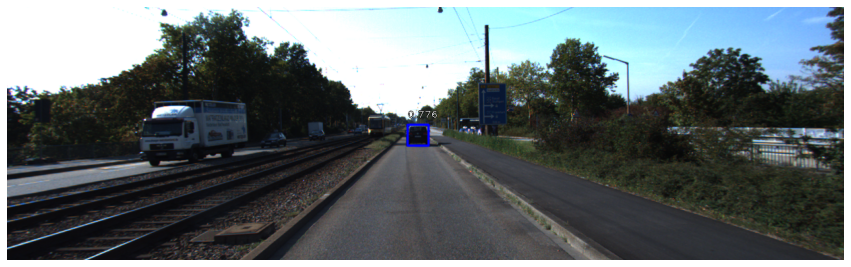

In [15]:
import os
img_path = os.getenv('HOME')+'/AIFFEL/Going_Deeper/GD6_Object_Detection_System/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)